**Load the Libraries**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.base import clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder

import warnings
warnings.filterwarnings('ignore')

**Load the Data**

1. Historical sales (train_test) – Ryanair sales for the full 12m starting from November
’22 till Oct ‘23
2. Future flights (predict_november) – details of the November ’23 flights. You have to
forecast fresh food sales for these flights. Nevertheless, be aware that the output file
with your predictions has to contain the forecast at Line of Flights level.
3. Planned lines of flight (real vs planned lofs_1_year; tab: planned rim lof) – a list of
planned lines of flight from November’22 till November’23.
4. Actual lines of flight (real vs planned lofs_1_year; tab: real netline lof) – a list of
actual lines of flight from November’22 till November ’23.

In [4]:
train_set = pd.read_csv("train_test.csv")
test_set = pd.read_csv("predict_november.csv")
planned_routes = pd.read_excel("real vs planned lofs_1_year.xlsx", sheet_name = "planned rim lof ")
actual_routes = pd.read_excel("real vs planned lofs_1_year.xlsx", sheet_name = "real netline lof")

**EDA (Exploratory Data Analysis)**

In [5]:
# The difference in the number of features between the training set and the testing set is due to the target variables.
# Target variables, each, has been represented as a single column, showing the amount.

print(f"The Shape of the Training Set: {train_set.shape}\n")
print(f"The Shape of the Test Set: {test_set.shape}\n")
print(f"The Shape of the Planned Routes Set: {planned_routes.shape}\n")
print(f"The Shape of the Actual Set: {actual_routes.shape}")

The Shape of the Training Set: (968876, 61)

The Shape of the Test Set: (64481, 55)

The Shape of the Planned Routes Set: (202462, 4)

The Shape of the Actual Set: (199729, 5)


In [6]:
train_set.columns

Index(['st_flight_id', 'st_departure_airport', 'st_arrival_airport',
       'st_departure_city', 'st_arrival_city', 'st_departure_country',
       'st_arrival_country', 'st_route_group', 'st_route_subgroup',
       'dt_flight_date', 'qt_departure_local_time', 'qt_arrival_local_time',
       'qt_flight_duration', 'qt_month_departure', 'qt_dayofweek_departure',
       'qt_total_passengers', 'qt_total_adult', 'qt_total_teen',
       'qt_total_child', 'qt_total_infant', 'qt_total_male', 'qt_total_female',
       'vl_mean_people_booking', 'vl_max_people_booking',
       'qt_outbound_passengers', 'qt_return_passengers', 'qt_passenger_oneway',
       'qt_total_bags', 'qt_total_golf', 'qt_total_ski', 'qt_total_bike',
       'qt_total_bulk', 'qt_total_music', 'qt_total_sportother',
       'qt_total_plus', 'qt_total_flexiplus', 'qt_total_bookings',
       'qt_total_1male', 'qt_total_1female', 'qt_total_2males',
       'qt_total_2females', 'qt_total_3males_plus', 'qt_total_3females_plus',
       

In [7]:
test_set.columns

Index(['st_flight_id', 'st_departure_airport', 'st_arrival_airport',
       'st_departure_city', 'st_arrival_city', 'st_departure_country',
       'st_arrival_country', 'st_route_group', 'st_route_subgroup',
       'dt_flight_date', 'qt_departure_local_time', 'qt_arrival_local_time',
       'qt_flight_duration', 'qt_month_departure', 'qt_dayofweek_departure',
       'qt_total_passengers', 'qt_total_adult', 'qt_total_teen',
       'qt_total_child', 'qt_total_infant', 'qt_total_male', 'qt_total_female',
       'vl_mean_people_booking', 'vl_max_people_booking',
       'qt_outbound_passengers', 'qt_return_passengers', 'qt_passenger_oneway',
       'qt_total_bags', 'qt_total_golf', 'qt_total_ski', 'qt_total_bike',
       'qt_total_bulk', 'qt_total_music', 'qt_total_sportother',
       'qt_total_plus', 'qt_total_flexiplus', 'qt_total_bookings',
       'qt_total_1male', 'qt_total_1female', 'qt_total_2males',
       'qt_total_2females', 'qt_total_3males_plus', 'qt_total_3females_plus',
       

In [8]:
# 6 Targets

target_list = ['Ham_Cheese_Panini_qt', 'Chicken_Seeded_Panini_qt',
               'Ham_Cheese_Croissant_qt', 'Fresh_Sandwich_qt', 'Choc_Croissant_qt',
               'Bacon_Baguette_qt']

In [9]:
# Numerical and Categorical Features

numerical_features = list(train_set._get_numeric_data())
categorical_features = list(train_set.drop(numerical_features, axis = 1))

numerical_features = [feature for feature in numerical_features if feature not in target_list]

In [10]:
def description(df):
    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc['min'] = df.min()
    desc['max'] = df.max()

    return desc

train_set_description = description(train_set)
test_set_description = description(test_set)

In [11]:
train_set_description

,type,count,nunique,%unique,null,%null,min,max
st_flight_id,object,968876,968876,100.000000,0,0.000000,20221001FR1000,20231027FR9997
st_departure_airport,object,968876,242,0.024977,0,0.000000,AAL,ZTH
st_arrival_airport,object,968876,245,0.025287,0,0.000000,AAL,ZTH
st_departure_city,object,926407,196,0.020230,42469,4.383327,NaN,NaN
st_arrival_city,object,926401,197,0.020333,42475,4.383946,NaN,NaN
...,...,...,...,...,...,...,...,...
Chicken_Seeded_Panini_qt,float64,613453,27,0.002787,355423,36.684055,0.0,27.0
Ham_Cheese_Croissant_qt,float64,613453,21,0.002167,355423,36.684055,0.0,36.0
Fresh_Sandwich_qt,float64,613453,37,0.003819,355423,36.684055,0.0,45.0
Choc_Croissant_qt,float64,613453,14,0.001445,355423,36.684055,0.0,24.0


In [12]:
test_set_description

,type,count,nunique,%unique,null,%null,min,max
st_flight_id,object,64481,64481,100.000000,0,0.000000,20231101FR10,20231130FR9962
st_departure_airport,object,64481,217,0.336533,0,0.000000,AAL,ZTH
st_arrival_airport,object,64481,218,0.338084,0,0.000000,AAL,ZTH
st_departure_city,object,61335,180,0.279152,3146,4.878957,NaN,NaN
st_arrival_city,object,61340,181,0.280703,3141,4.871202,NaN,NaN
st_departure_country,object,61335,33,0.051178,3146,4.878957,NaN,NaN
st_arrival_country,object,61340,33,0.051178,3141,4.871202,NaN,NaN
st_route_group,object,64480,6,0.009305,1,0.001551,NaN,NaN
st_route_subgroup,object,64480,46,0.071339,1,0.001551,NaN,NaN
dt_flight_date,int64,64481,30,0.046525,0,0.000000,20231101,20231130


In [13]:
# Drop the st_flight_id Column

train_set = train_set.drop("st_flight_id", axis=1)
test_set = test_set.drop("st_flight_id", axis=1)

categorical_features.remove("st_flight_id")

In [14]:
print(f"The Number of Duplicate Rows in the Training Set: {train_set.duplicated().sum()}\n")

The Number of Duplicate Rows in the Training Set: 0



In [15]:
# Check NaN Values in the Dependent Variables

nan_rows = train_set[target_list].isnull().any(axis=1)
train_set_with_nan = train_set[nan_rows]

print(f"The Number of Rows with NaN Dependent Variables Are: {train_set_with_nan.shape}")

The Number of Rows with NaN Dependent Variables Are: (355423, 60)


In [16]:
# Drop the Rows where there are NaN Values

train_set = train_set.dropna(subset=target_list)

print(f"The Shape of the Training Set without NaN Values: {train_set.shape}\n")

The Shape of the Training Set without NaN Values: (613453, 60)



**EDA Dependent Variables**

In [17]:
print(f"The Targets Are:\n {target_list}")

# Creating a DataFrame Consisting Only of the Target Columns
dependents_set = train_set[target_list]

The Targets Are:
 ['Ham_Cheese_Panini_qt', 'Chicken_Seeded_Panini_qt', 'Ham_Cheese_Croissant_qt', 'Fresh_Sandwich_qt', 'Choc_Croissant_qt', 'Bacon_Baguette_qt']


In [18]:
train_set_description = description(dependents_set)
train_set_description

,type,count,nunique,%unique,null,%null,min,max
Ham_Cheese_Panini_qt,float64,613453,49,0.007988,0,0.0,0.0,88.0
Chicken_Seeded_Panini_qt,float64,613453,27,0.004401,0,0.0,0.0,27.0
Ham_Cheese_Croissant_qt,float64,613453,21,0.003423,0,0.0,0.0,36.0
Fresh_Sandwich_qt,float64,613453,37,0.006031,0,0.0,0.0,45.0
Choc_Croissant_qt,float64,613453,14,0.002282,0,0.0,0.0,24.0
Bacon_Baguette_qt,float64,613453,23,0.003749,0,0.0,0.0,32.0


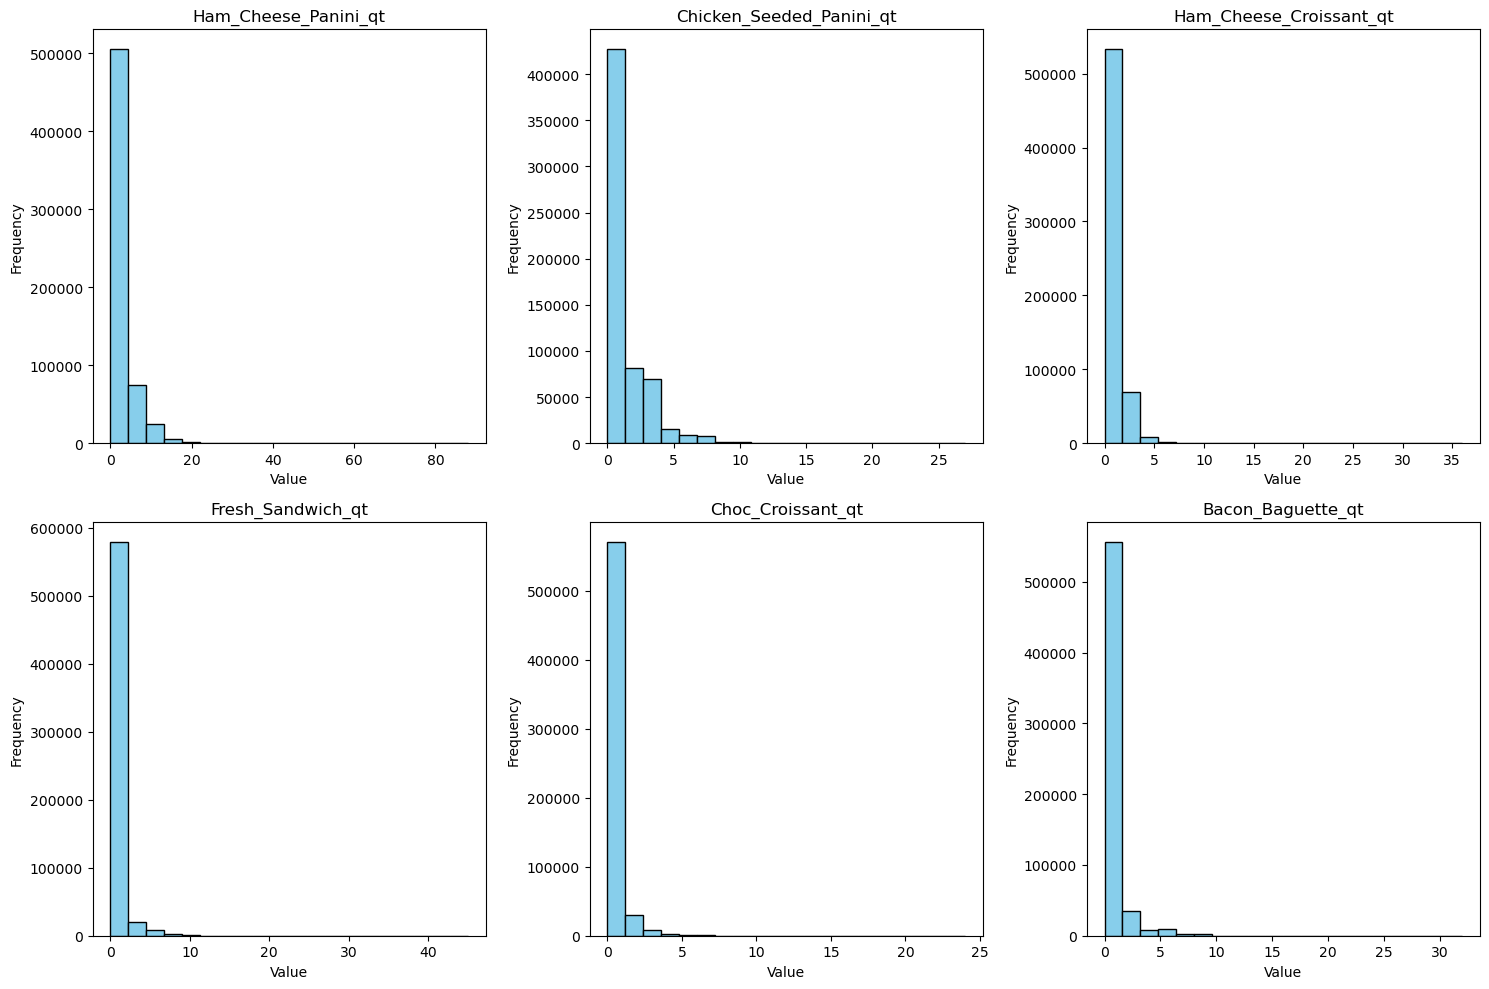

In [19]:
# The Histogram of the Dependent Variables

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, target in enumerate(target_list):
    axs[i].hist(dependents_set[target].dropna(), bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(target)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

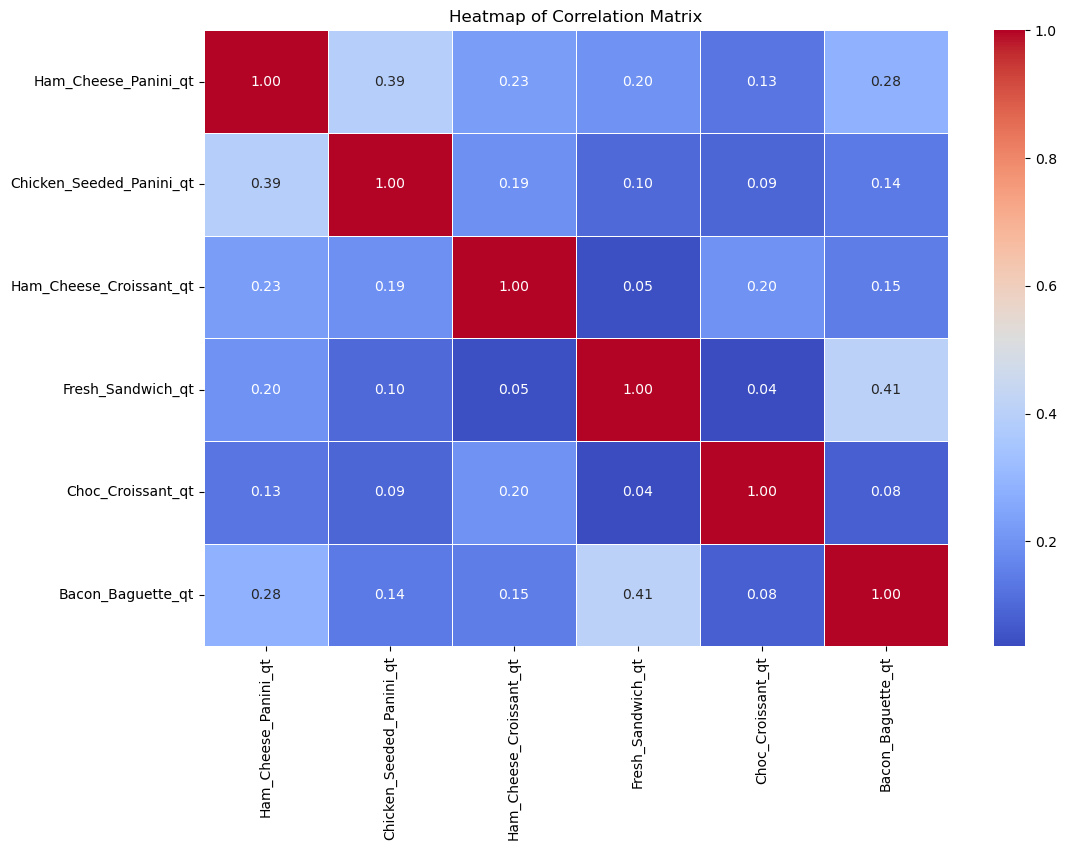

In [20]:
# Dependent Variables Correlation Matrix

correlation_matrix = train_set[target_list].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

**EDA Independent Variables**

In [21]:
print(f"The Numerical Features Are:\n {numerical_features}")

The Numerical Features Are:
 ['dt_flight_date', 'qt_departure_local_time', 'qt_arrival_local_time', 'qt_flight_duration', 'qt_month_departure', 'qt_dayofweek_departure', 'qt_total_passengers', 'qt_total_adult', 'qt_total_teen', 'qt_total_child', 'qt_total_infant', 'qt_total_male', 'qt_total_female', 'vl_mean_people_booking', 'vl_max_people_booking', 'qt_outbound_passengers', 'qt_return_passengers', 'qt_passenger_oneway', 'qt_total_bags', 'qt_total_golf', 'qt_total_ski', 'qt_total_bike', 'qt_total_bulk', 'qt_total_music', 'qt_total_sportother', 'qt_total_plus', 'qt_total_flexiplus', 'qt_total_bookings', 'qt_total_1male', 'qt_total_1female', 'qt_total_2males', 'qt_total_2females', 'qt_total_3males_plus', 'qt_total_3females_plus', 'qt_total_3malefemale_mixed', 'qt_total_rest_composition', 'AC_LOGICAL_NO', 'FN_NUMBER', 'dep_delay']


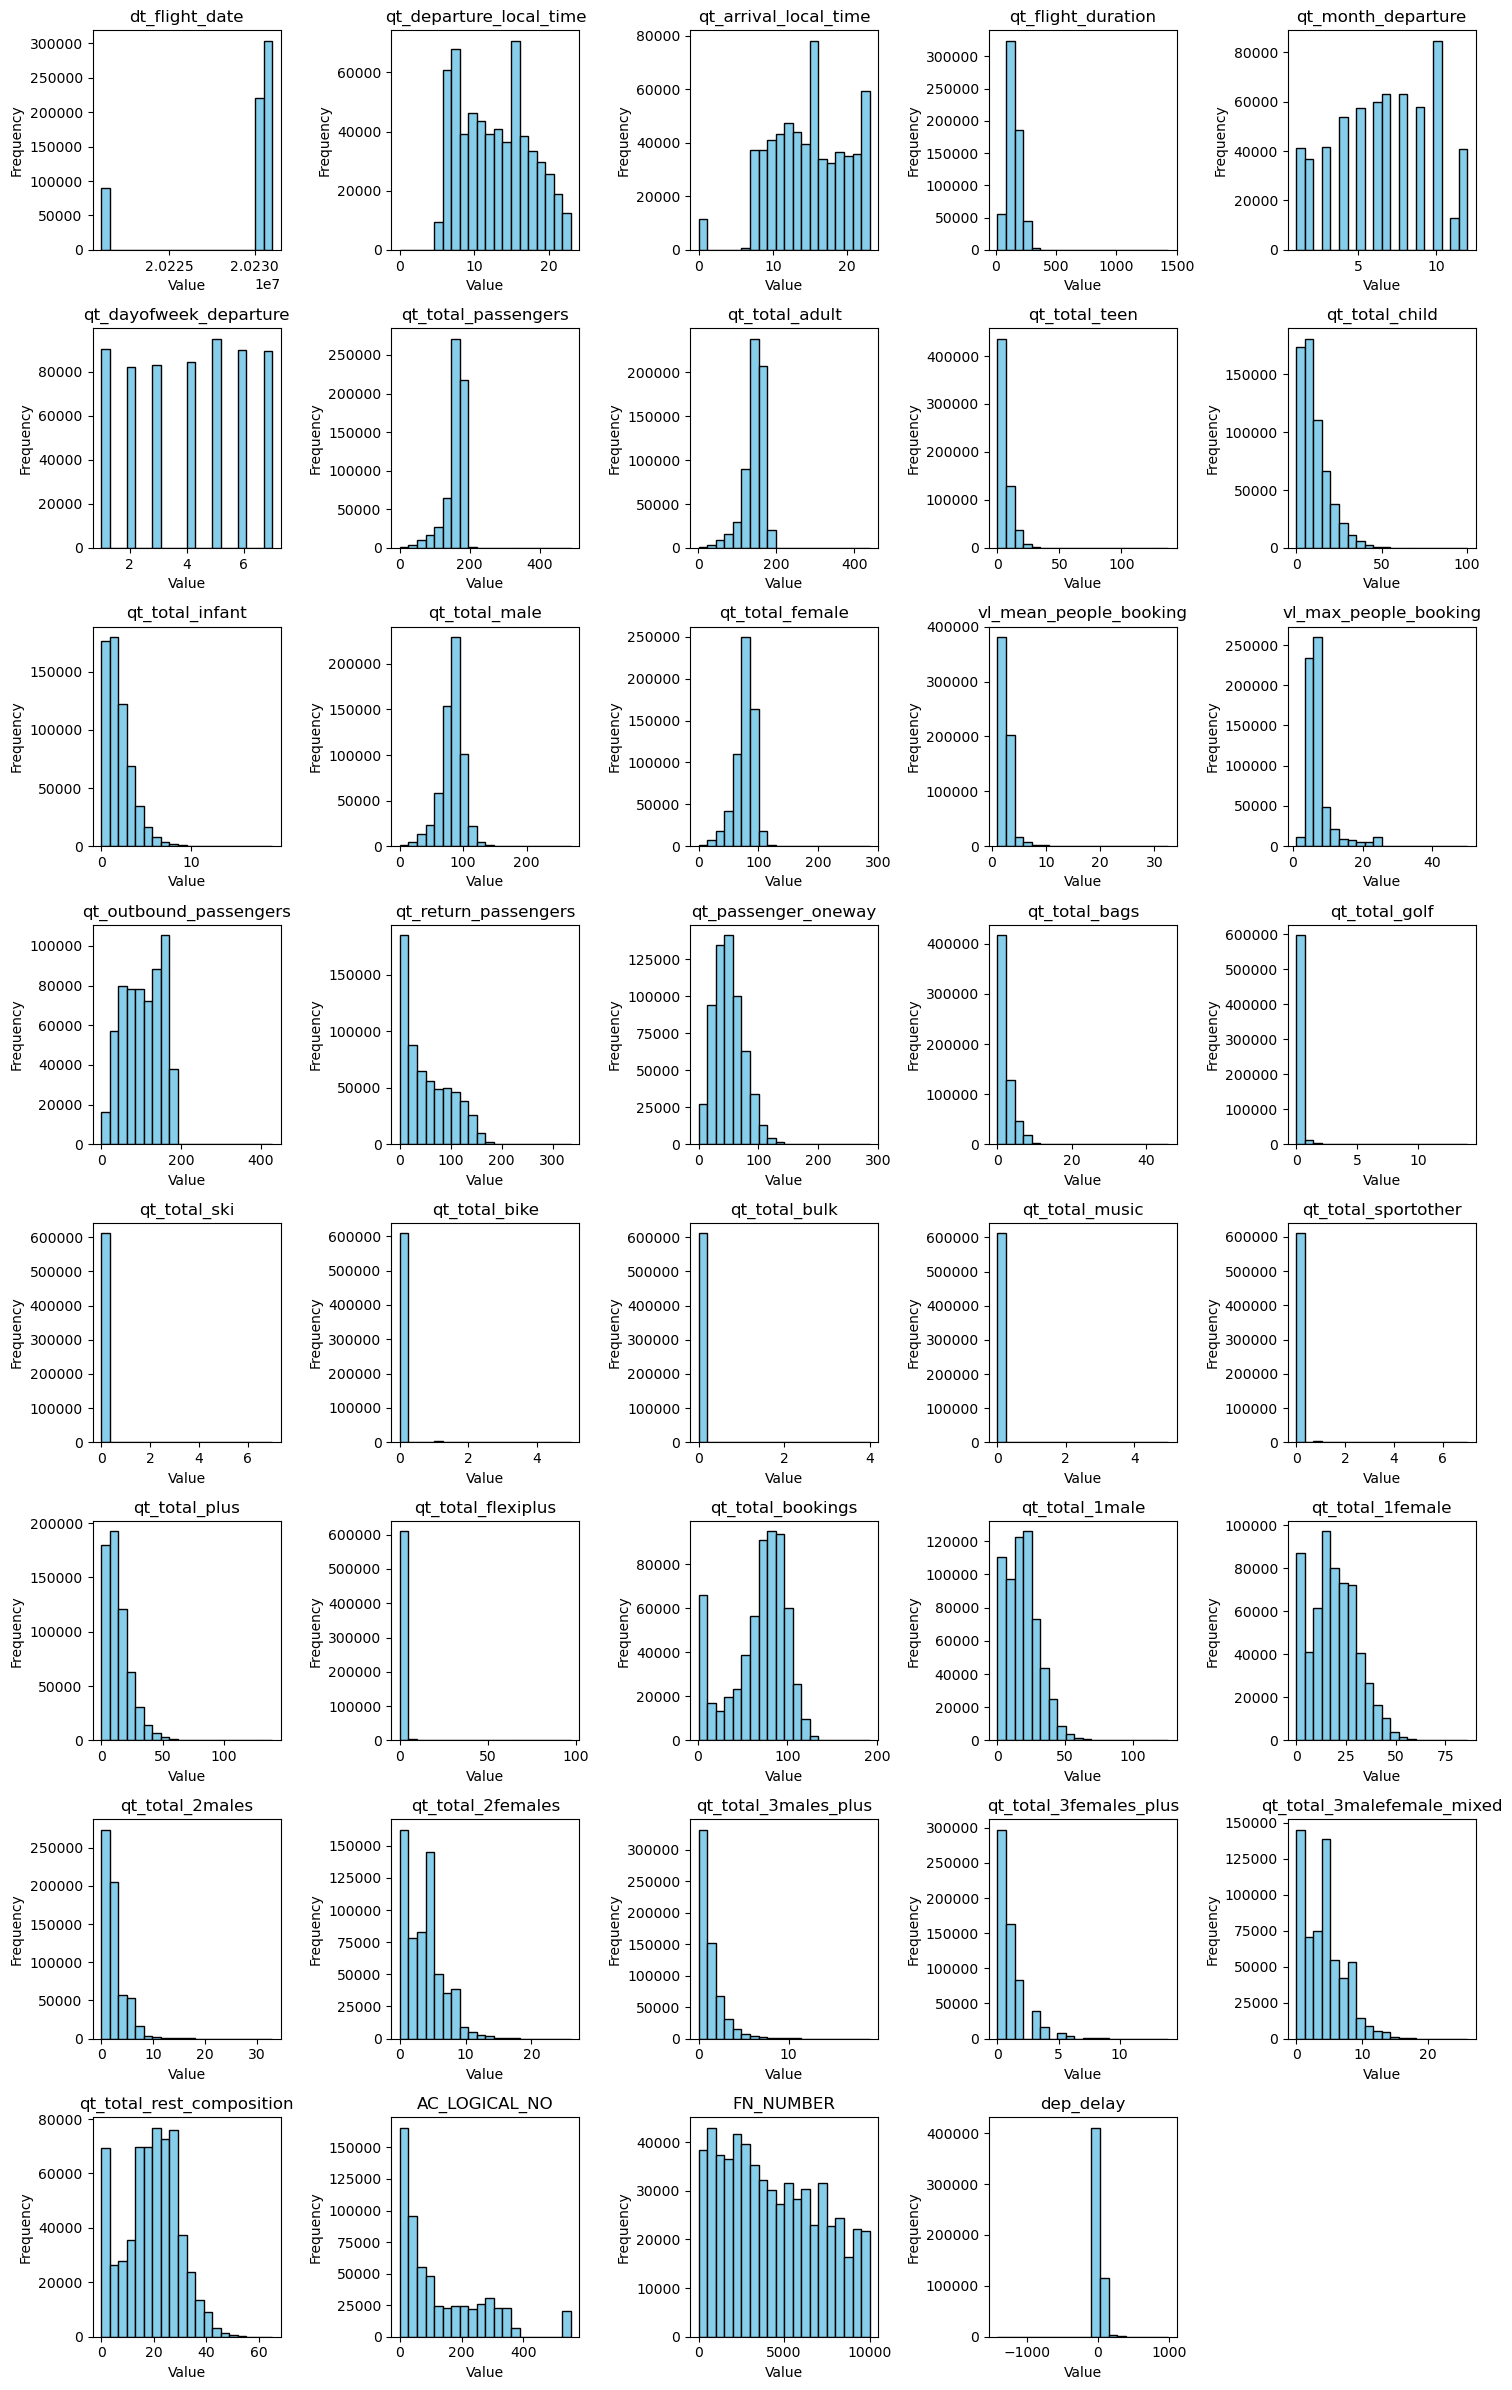

In [22]:
# Numerical Features Histograms

n_features = len(numerical_features)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axs = axs.flatten()

for i, feature in enumerate(numerical_features):
    axs[i].hist(train_set[feature].dropna(), bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(feature)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

for ax in axs[len(numerical_features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

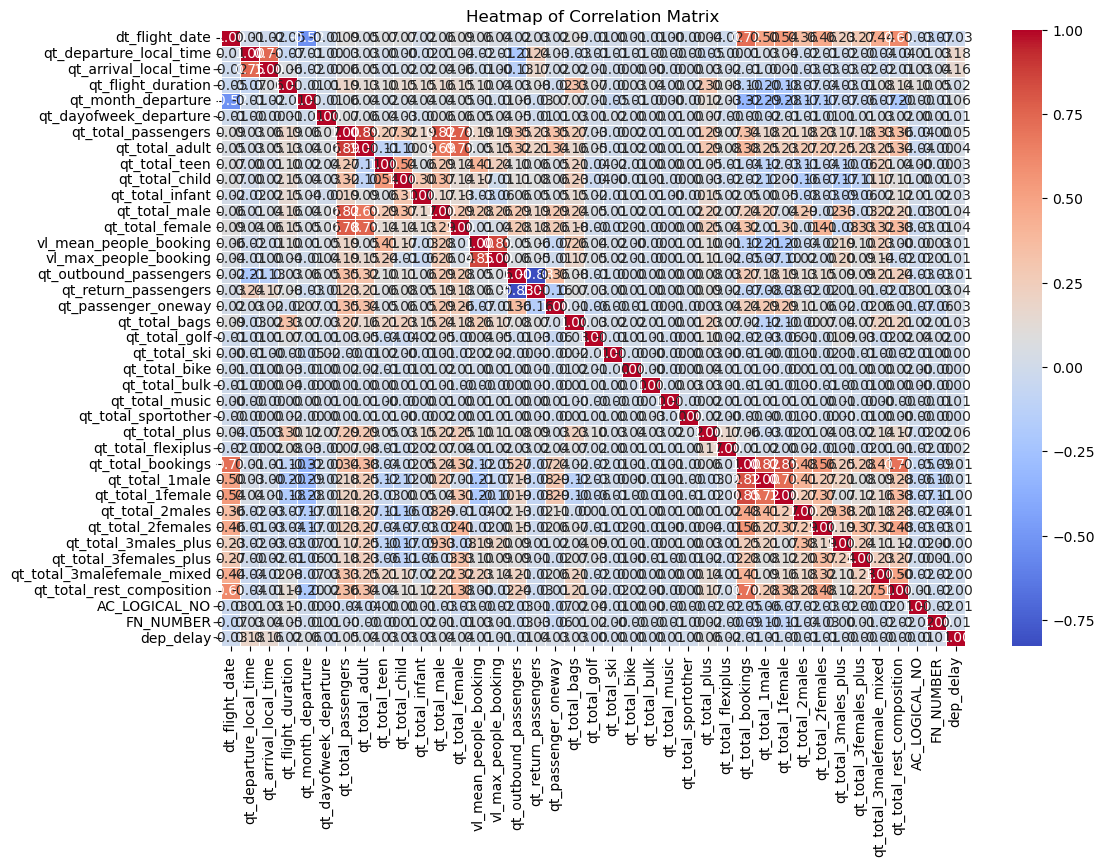

In [23]:
# Numerical Features Correlation Matrix

correlation_matrix = train_set[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [24]:
print(f"The Categorical Features Are:\n {categorical_features}")

The Categorical Features Are:
 ['st_departure_airport', 'st_arrival_airport', 'st_departure_city', 'st_arrival_city', 'st_departure_country', 'st_arrival_country', 'st_route_group', 'st_route_subgroup', 'DAY_OF_ORIGIN', 'DEP_SCHED_DT', 'ARR_SCHED_DT', 'FN_CARRIER', 'Base', 'Lof_ID', 'Flight_n']


**Preparation**

In [25]:
X = train_set.drop(columns=target_list)
y = train_set[target_list]

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (613453, 54)
y.shape: (613453, 6)


In [26]:
# Creating 6 Different Target Variables

y_ham_cheese_panini = y.loc[:, "Ham_Cheese_Panini_qt"]
y_chicken_seed_panini = y.loc[:, "Chicken_Seeded_Panini_qt"]
y_ham_cheese_croissant_croissant = y.loc[:, "Ham_Cheese_Croissant_qt"]
y_fresh_sandwich = y.loc[:, "Fresh_Sandwich_qt"]
y_choc_croissant = y.loc[:, "Choc_Croissant_qt"]
y_bacon_baguette = y.loc[:, "Bacon_Baguette_qt"]

In [27]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

**Model**

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import numpy as np
import optuna

n_splits = 10
kf = KFold(n_splits=n_splits)

def cross_val_model(estimators, X, y, test_set, cv, verbose=True):
    val_scores = []
    val_preds = np.zeros(len(X))
    test_preds = np.zeros(len(test_set))

    for fold, (train_ind, val_ind) in enumerate(cv.split(X)):
        model = clone(estimators)

        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]

        model.fit(X_train, y_train)

        val_pred = model.predict(X_val)
        val_preds[val_ind] = val_pred
        mse = mean_squared_error(y_val, val_pred)

        test_fold_pred = model.predict(test_set)
        test_preds += test_fold_pred / cv.n_splits

        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")
            print(f"Validation MSE Score: {mse}")
            print("-" * 100)

        val_scores.append(mse)

    if verbose:
        print(f"Average Validation MSE Score: {np.mean(val_scores)}")

    return val_scores, val_preds, test_preds

**XGBoost Model**

In [29]:
def xgb_objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 24),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
    }

    xgb_model = make_pipeline(
        MEstimateEncoder(cols=categorical_features),
        XGBRegressor(**params, random_state=42)
    )

    val_scores, _, _ = cross_val_model(xgb_model, X, y_ham_cheese_panini, test_set, kf, verbose=False)

    return np.mean(val_scores)

xgb_study = optuna.create_study(direction='minimize')

[I 2024-03-01 10:29:34,917] A new study created in memory with name: no-name-afe3b5cc-f3cc-4451-bb09-a531ffe39d3d


In [30]:
# Tune Using Optuna
TUNE = True

if TUNE:
    xgb_study.optimize(xgb_objective, 10)


"[I 2024-02-28 20:48:15,891] Trial 2 finished with value: 4.867661855092419e+34 and parameters: {'grow_policy': 'lossguide', 'n_estimators': 1099, 'learning_rate': 0.9915569700906465, 'gamma': 0.8919117403744115, 'subsample': 0.41608947246825356, 'colsample_bytree': 0.3719050649893853, 'max_depth': 22, 'min_child_weight': 3, 'reg_lambda': 4.497397110494663e-06, 'reg_alpha': 2.698661838055659e-07}. Best is trial 0 with value: 9.674193046809174."

[I 2024-03-01 10:32:50,937] Trial 0 finished with value: 9.247028264902061 and parameters: {'grow_policy': 'depthwise', 'n_estimators': 466, 'learning_rate': 0.337115797311687, 'gamma': 0.46464283792979943, 'subsample': 0.7169091773172763, 'colsample_bytree': 0.3146446882968339, 'max_depth': 0, 'min_child_weight': 21, 'reg_lambda': 3.483199287417511e-09, 'reg_alpha': 1.5773506963284988e-07}. Best is trial 0 with value: 9.247028264902061.
[I 2024-03-01 10:34:40,173] Trial 1 finished with value: 9.360523782927201 and parameters: {'grow_policy': 'depthwise', 'n_estimators': 661, 'learning_rate': 0.39384332759260443, 'gamma': 0.7226677658144506, 'subsample': 0.8821928780472446, 'colsample_bytree': 0.8531664109531257, 'max_depth': 3, 'min_child_weight': 14, 'reg_lambda': 6.886912976392951e-09, 'reg_alpha': 0.0907976859883537}. Best is trial 0 with value: 9.247028264902061.
[I 2024-03-01 10:41:15,877] Trial 2 finished with value: 11.191810445799925 and parameters: {'grow_policy': 'lossguide'

"[I 2024-02-28 20:48:15,891] Trial 2 finished with value: 4.867661855092419e+34 and parameters: {'grow_policy': 'lossguide', 'n_estimators': 1099, 'learning_rate': 0.9915569700906465, 'gamma': 0.8919117403744115, 'subsample': 0.41608947246825356, 'colsample_bytree': 0.3719050649893853, 'max_depth': 22, 'min_child_weight': 3, 'reg_lambda': 4.497397110494663e-06, 'reg_alpha': 2.698661838055659e-07}. Best is trial 0 with value: 9.674193046809174."

In [31]:
best_params = xgb_study.best_params
print(best_params)

{'grow_policy': 'depthwise', 'n_estimators': 310, 'learning_rate': 0.08461955124635362, 'gamma': 0.9762110216465913, 'subsample': 0.8474872146737105, 'colsample_bytree': 0.6900803059464959, 'max_depth': 1, 'min_child_weight': 2, 'reg_lambda': 3.109113023263905e-08, 'reg_alpha': 1.0041171796390681e-07}


In [32]:
XGB = make_pipeline(
    MEstimateEncoder(cols=categorical_features),
    XGBClassifier(**best_params,seed=seed)
)

NameError: name 'seed' is not defined

In [ ]:
# Train the Model

val_scores, val_predictions, test_predictions = cross_val_model(XGB, X, y)

for k,v in mapping.items():
    oof_list[f"xgb_{k}"] = val_predictions[:,v]

for k,v in mapping.items():
    predict_list[f"xgb_{k}"] = test_predictions[:,v]